In [1]:
import os
import time

from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cv2

import torch
from torch import nn, optim
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F


In [2]:
DATASET_FILEPATH = Path('/kaggle/input/leapgestrecog/leapGestRecog/')
IMG_SIZE = 256
RANDOM_STATE = 42

Подготовка датасета

In [3]:
import re

def gest_label_encoding(gest):
    code = re.findall('^\d*', gest)[0]
    return int(code)-1

def make_df_from_files(parent_dir_path=DATASET_FILEPATH):
    result = list()
    for person in os.listdir(parent_dir_path):
        person_path = parent_dir_path.joinpath(person)
        for gest in os.listdir(person_path):
            gest_path = person_path.joinpath(gest)
            for img in os.listdir(gest_path):
                result.append([img, gest_path.joinpath(img), gest_label_encoding(gest), person])
                    
    return result

In [4]:
gest_df = pd.DataFrame(make_df_from_files(), columns=('img', 'path', 'gest', 'person'))
gest_df.sample(5)

,img,path,gest,person
4803,frame_06_06_0088.png,/kaggle/input/leapgestrecog/leapGestRecog/06/0...,5,06
2998,frame_05_06_0078.png,/kaggle/input/leapgestrecog/leapGestRecog/05/0...,5,05
13912,frame_08_03_0101.png,/kaggle/input/leapgestrecog/leapGestRecog/08/0...,2,08
19292,frame_01_07_0094.png,/kaggle/input/leapgestrecog/leapGestRecog/01/0...,6,01
7303,frame_02_07_0122.png,/kaggle/input/leapgestrecog/leapGestRecog/02/0...,6,02


In [5]:
gest_df['gest'].unique()

array([1, 3, 8, 9, 5, 7, 6, 4, 0, 2])

In [6]:
class LeapGests(torch.utils.data.Dataset):
    def __init__(self, data, preprocessing=None):
        self.data = data
        self.preprocessing = preprocessing
        
        self.image_paths = self.data.iloc[:, 1]
        self.image_gest = self.data.iloc[:, 2]
        self.data_len = len(self.data.index)
        
    def __len__(self):
        return self.data_len
        
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path)
        
        if self.preprocessing is not None:
            img = self.preprocessing(img)
        
        gest = self.image_gest[idx]

        return img, gest

In [7]:
train_tfms = transforms.Compose([transforms.Grayscale(num_output_channels=3),
                                    transforms.Resize([IMG_SIZE, IMG_SIZE]),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(30),
                                    transforms.ToTensor()])

valid_tfms = transforms.Compose([transforms.Grayscale(num_output_channels=3), transforms.ToTensor()])

In [8]:
batch_size = 64

train_dataset = LeapGests(gest_df, train_tfms)
valid_dataset = LeapGests(gest_df, valid_tfms)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=1)

torch.Size([64, 3, 256, 256])
tensor(8)


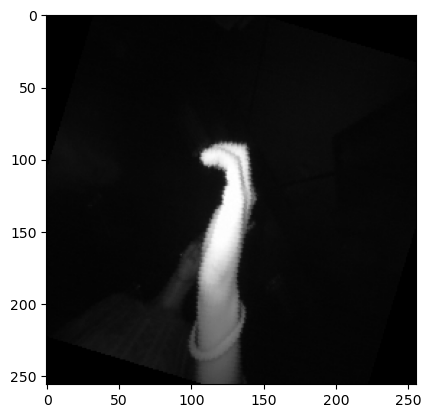

In [9]:
for img, lbl in train_loader:
    print(img.shape)
    print(lbl[0])
    plt.imshow(img[0].permute(1, 2, 0)[:,:,0], cmap='gray')
    break

Resnet

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
!pip install torchsummary

In [ ]:
from torchsummary import summary
from torchvision import models

In [ ]:
resnet50 = models.resnet50(pretrained=True)

In [ ]:
for param in list(resnet50.parameters())[:]:
  param.requires_grad = False

In [ ]:
resnet50.fc = nn.Linear(2048, 10)

In [ ]:
summary(resnet50.to(device), input_size=(3, 32, 32))

In [ ]:
resnet50 = resnet50.to(device)

In [ ]:
params_to_update = []
for name,param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = torch.optim.Adam(params_to_update, lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
epochs = 10
epoch_losses = []

for epoch in range(epochs):
    
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = resnet50(data)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        
    test_running_loss = 0
    test_epoch_loss = []
    for batch_idx, (data, labels) in enumerate(valid_loader):
        resnet50.eval()
        data = data.to(device)
        labels = labels.to(device)
        
        outputs = resnet50(data)
        loss = F.cross_entropy(outputs, labels)
                
        test_running_loss += loss.item()
        test_epoch_loss.append(loss.item())
        
        
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss), 'test loss:', np.mean(test_epoch_loss))
    epoch_losses.append(epoch_loss)

In [ ]:
torch.save(resnet50, './gest_detection_model.pth')

In [ ]:
with torch.no_grad():
    for i, data in enumerate(valid_loader, 3):
        images, labels = data[0].to(device), data[1].to(device)
        
        outputs = resnet50(images)
        plt.title(f'pred - {outputs[0].argmax()}, gt - {labels[0]}')
        plt.imshow(images[0].cpu().permute(1, 2, 0), cmap='gray')
        plt.show()
        if i>15:
            break